In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'
# path_to_git = '/home/kentaro/github/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=2)

In [26]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

# Controlling for age

In [400]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}

for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Age',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = []
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 30
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means

100%|██████████| 3/3 [1:32:53<00:00, 1857.76s/it]


In [401]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
#                                                                        & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

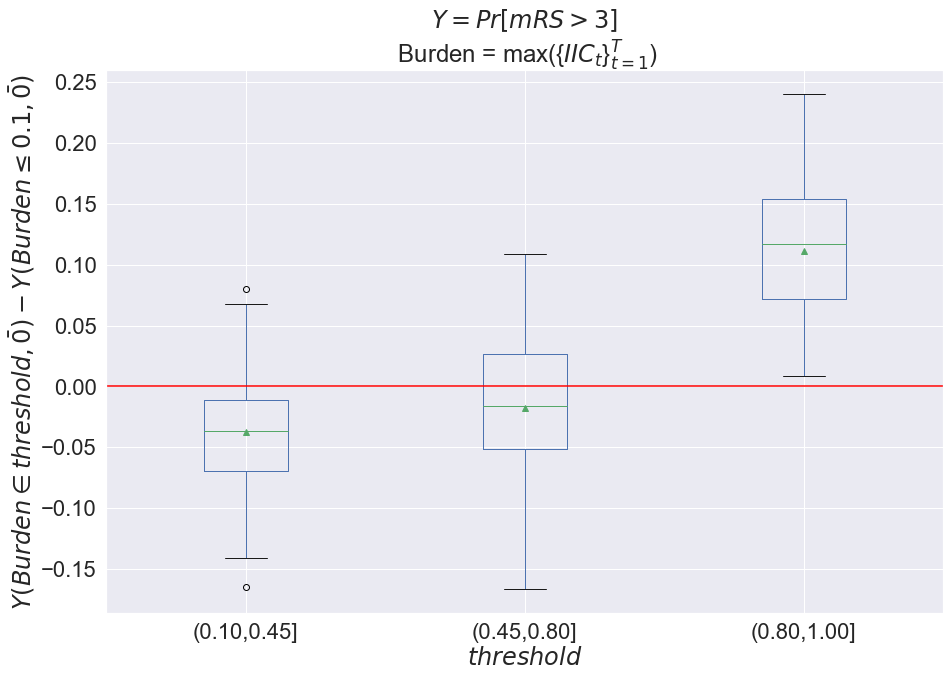

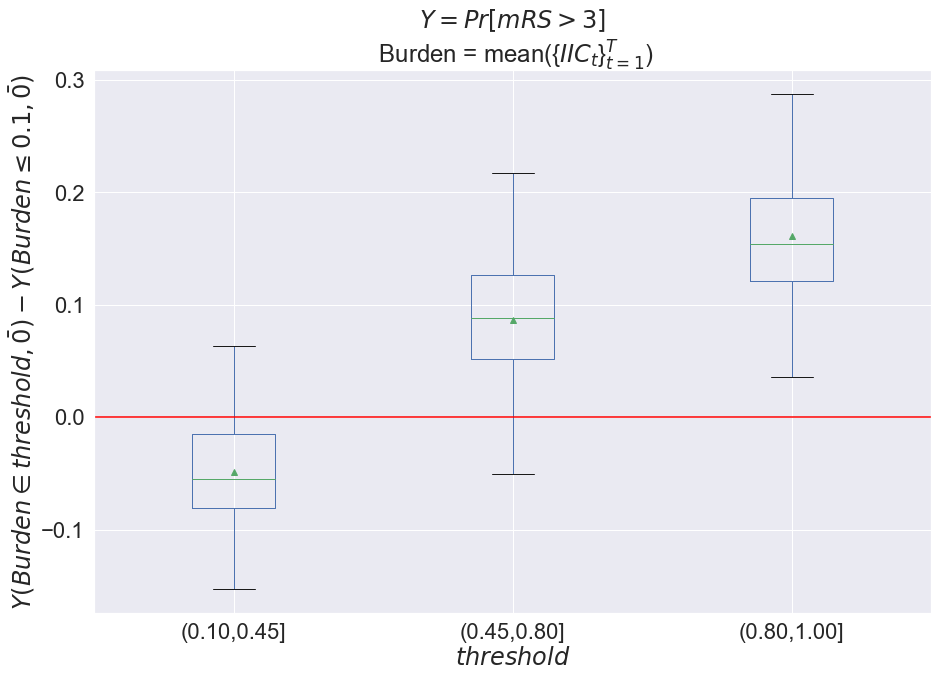

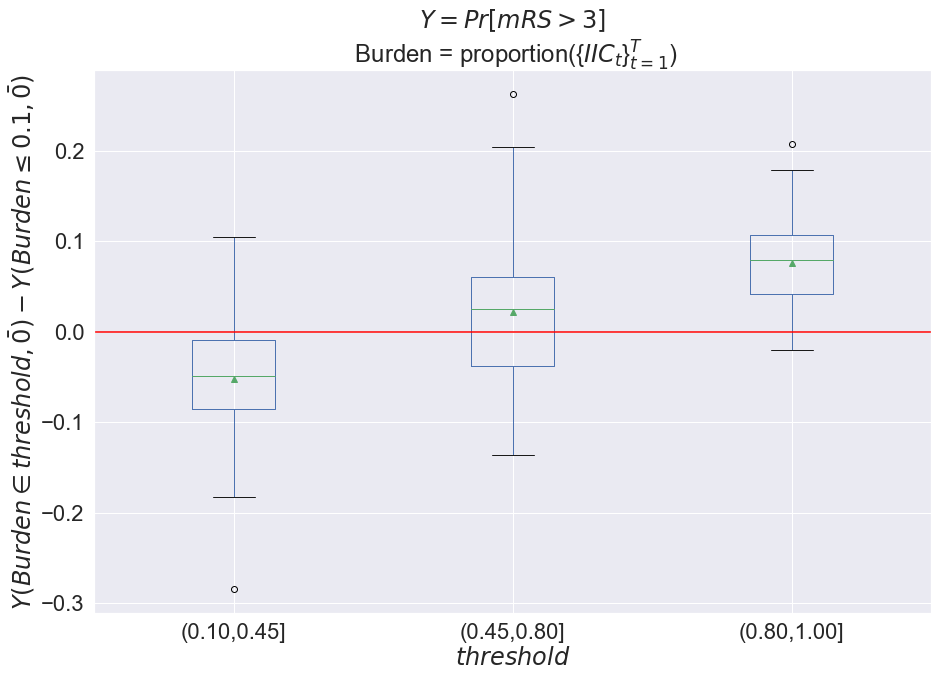

In [402]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(15,10))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,ax=ax)
    plt.axhline(0,c='red')
    plt.ylabel('$Y(Burden \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$')
    plt.xlabel('$threshold$')
    plt.title('$Y = Pr[mRS > 3]$\n Burden = %s({$IIC_t$}$_{t=1}^T$)'%(type_summary))
    fig.savefig(type_summary+'_age.png')

In [403]:
df_m_atec

,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,...,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE,ATE
"(0.10,0.45]",-0.070968,-0.064957,-0.055652,-0.001709,-0.081034,-0.115447,-0.034711,-0.064865,-0.038710,0.086239,...,0.003509,-0.066667,-0.076562,0.005405,-0.121667,-0.071667,-0.027586,0.022222,-0.182143,0.006299
"(0.45,0.80]",0.140741,-0.067890,-0.003540,0.127273,-0.016807,-0.049505,0.018519,-0.079646,0.018349,-0.046847,...,-0.035398,-0.071429,0.054000,0.025424,0.020690,0.055357,-0.066667,0.013793,0.014286,-0.015686
"(0.80,1.00]",0.085207,0.022078,0.103401,0.101316,0.041212,0.100654,0.082635,0.055346,0.090278,0.061935,...,0.129560,0.087805,0.151282,0.014667,0.162264,-0.020382,0.080519,0.051948,0.104575,0.094479


# Controlling for all pre-admission covariates

In [404]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}

for type_summary in tqdm.tqdm(['max','mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission', 
                'hydrocephalus  (either on admission or during hospital course)   QPID', 
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 20
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means





100%|██████████| 3/3 [1:25:30<00:00, 1710.29s/it]


In [405]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

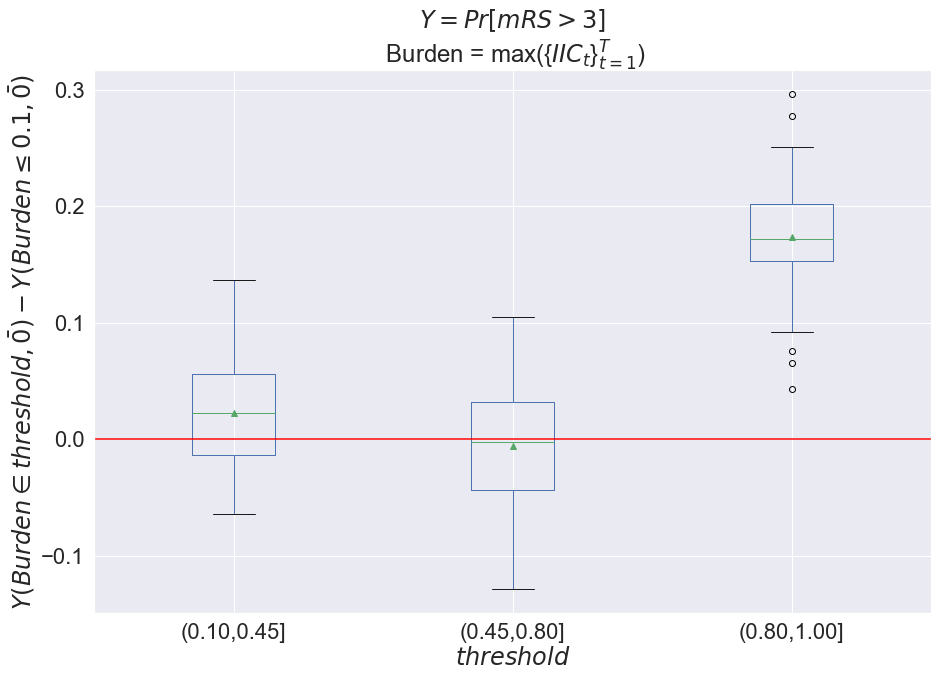

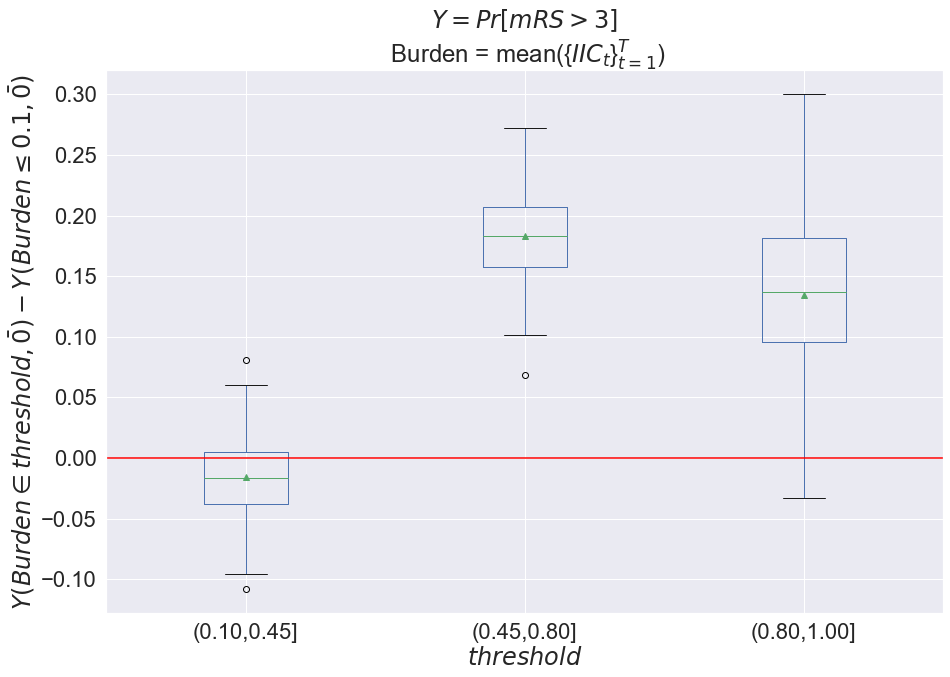

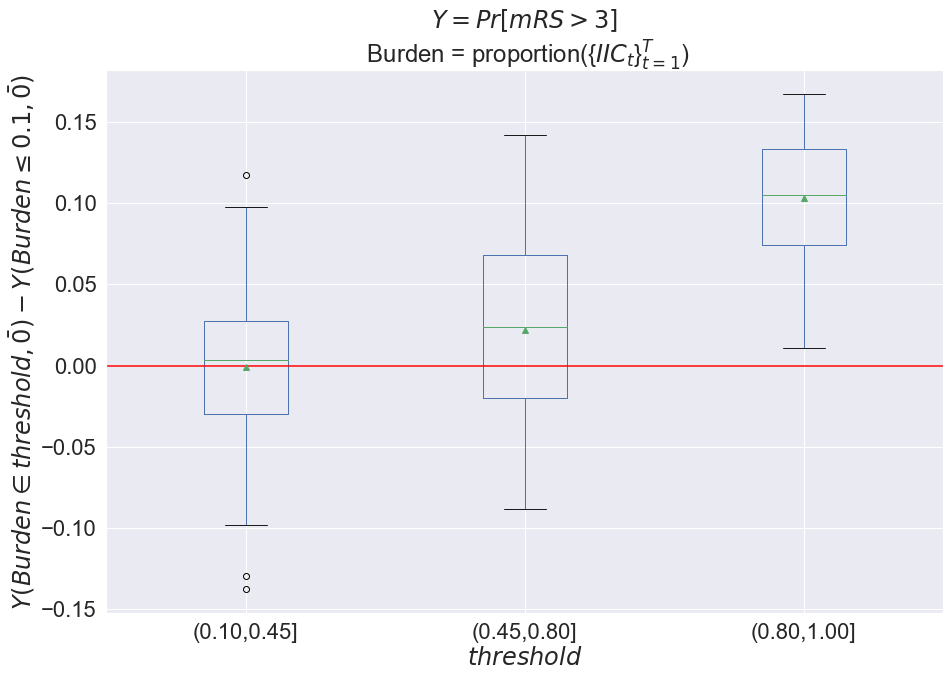

In [406]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(15,10))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,ax=ax)
    plt.axhline(0,c='red')
    plt.ylabel('$Y(Burden \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$')
    plt.xlabel('$threshold$')
    plt.title('$Y = Pr[mRS > 3]$\n Burden = %s({$IIC_t$}$_{t=1}^T$)'%(type_summary))
    fig.savefig(type_summary+'_c.png')

In [173]:
threshold = list(m_dict.keys())[3]
df_m_ate_ = m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                               & (df_dict[threshold]['propofol']<=1) 
                               & (df_dict[threshold]['midazolam']<=0.1)
                               & (df_dict[threshold]['lacosamide']<=0.1)
                               & (df_dict[threshold]['pentobarbital']<=0)
                               & (df_dict[threshold]['phenobarbital']<=0)
                               & (df_dict[threshold]['valproate']<=1)]
M_ = pd.concat(m_dict[threshold].M_opt_list)
MG_ = m_dict[threshold].MG_matrix.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                               & (df_dict[threshold]['propofol']<=1) 
                               & (df_dict[threshold]['midazolam']<=0)
                               & (df_dict[threshold]['lacosamide']<=0)
                               & (df_dict[threshold]['pentobarbital']<=0)
                               & (df_dict[threshold]['phenobarbital']<=0)
                               & (df_dict[threshold]['valproate']<=0)]
df_m_ate_[['T']].shape

(141, 1)

In [174]:
MG_0 = MG_.iloc[1]
MG_0 = MG_0[MG_0>0]
df_dict[threshold].loc[list(MG_0.index)].join(df_m_ate_[['avg.CATE','std.CATE','avg.Diameter']],how='inner').groupby('T').mean().T

T,False,True
Gender,0.531250,0.625000
Age,64.753750,60.625625
marrital,0.750000,0.562500
Hx CVA (including TIA),0.218750,0.125000
Hx HTN,0.656250,0.812500
Hx Sz /epilepsy,0.062500,0.375000
Hx brain surgery,0.062500,0.312500
Hx CKD,0.156250,0.000000
Hx CAD/MI,0.125000,0.187500
Hx CHF,0.031250,0.000000


<AxesSubplot:xlabel='avg.Diameter', ylabel='avg.CATE'>

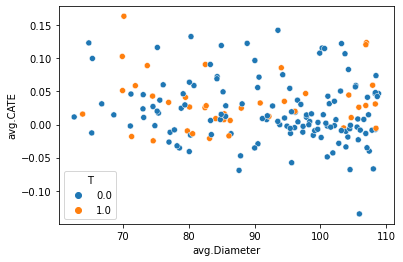

In [186]:
j = 3
cutoff = pd.concat(m_dict[list(m_dict.keys())[j]].M_opt_list).mean(axis=0).sort_values(ascending=False).sum()
# sns.scatterplot(data=df_m_ate_.loc[df_m_ate_['avg.Diameter']<400],x='avg.Diameter',y='avg.CATE')
sns.scatterplot(data=m_dict[list(m_dict.keys())[j]].CATE_df.loc[m_dict[list(m_dict.keys())[j]].CATE_df['avg.Diameter']<3*cutoff],x='avg.Diameter',y='avg.CATE',hue='T')

In [177]:
pd.concat(m_dict[list(m_dict.keys())[3]].M_opt_list).mean(axis=0).sort_values(ascending=False).sum()

36.36939398353506

In [178]:
pd.concat([pd.DataFrame(M_.mean(axis=0),columns=['mean']),pd.DataFrame(M_.min(axis=0),columns=['min']),pd.DataFrame(M_.max(axis=0),columns=['max'])],axis=1).sort_values(ascending=False,by='mean')

,mean,min,max
Age,1.566882,0.740884,2.260887
Hx CAD/MI,1.473368,0.658891,2.171397
Primary systemic dx Sepsis/Shock,1.432050,0.790735,2.135878
Hx CKD,1.404262,0.492308,2.600821
Hx CHF,1.387137,0.782976,2.365020
Hx CNS cancer,1.378336,0.436985,2.402994
midazolam,1.377397,0.240132,2.393124
propofol,1.309093,0.421461,2.130723
Worst GCS in 1st 24,1.221636,0.509815,2.633010
phenobarbital,1.213367,0.218100,2.411839


In [180]:
df_means

,Baseline,0.10 - 0.28,0.28 - 0.45,0.45 - 0.62,0.62 - 0.80,0.80 - 1.00
Gender,0.510490,0.502392,0.402985,0.530973,0.495935,0.460630
Age,58.091725,58.859904,58.896194,60.049558,60.937398,61.140709
marrital,0.475524,0.468900,0.470149,0.530973,0.479675,0.586614
Hx CVA (including TIA),0.186480,0.196172,0.156716,0.212389,0.170732,0.208661
Hx HTN,0.496503,0.492823,0.544776,0.504425,0.601626,0.566929
Hx Sz /epilepsy,0.142191,0.200957,0.171642,0.221239,0.203252,0.228346
Hx brain surgery,0.048951,0.114833,0.134328,0.123894,0.146341,0.161417
Hx CKD,0.118881,0.081340,0.141791,0.079646,0.130081,0.149606
Hx CAD/MI,0.174825,0.129187,0.134328,0.176991,0.203252,0.145669
Hx CHF,0.062937,0.086124,0.082090,0.097345,0.113821,0.114173


# Controlling for all pre-admission covariates and PKPD parameters

In [354]:
m_dict_dict = {}
cates_dict_dict = {}
df_dict_dict = {}
df_means_dict = {}

df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
                     index_col=0, header=0)

df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
                   'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)

for type_summary in tqdm.tqdm(['max','mean']):#,'mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission',  
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()
    
    df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')

    discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                'Hx CNS cancer', 'Hx COPD/ Asthma', 
                'premorbid MRS before admission  (modified ranking scale),before admission',
                'iMV  (initial (on admission) mechanical ventilation)',
                'Primary systemic dx Sepsis/Shock',
                'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 3
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<=baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
#     df_baseline_dict[type_summary] = df_coarsen_baseline
    num = []
    n_thresholds = 3
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    df_dict = {}
    
    df_means = pd.DataFrame(df_coarsen_baseline.mean(axis=0),columns=['Baseline'])
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] > threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<=upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_means_ = pd.DataFrame(df_coarsen_comparison.mean(axis=0),columns=['%.2f - %.2f'%(threshold,upper_threshold)])
        df_means = pd.concat([df_means,df_means_],axis=1)
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
         
        # malts object, match only on pre-treatment covariates
        n_repeats = 20
        n_splits = 3
        
        df_malts_data = (df_malts.drop(columns=['Y','T']).values - df_malts.drop(columns=['Y','T']).mean(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape))
        df_malts_data = pd.DataFrame(df_malts_data / (df_malts.drop(columns=['Y','T']).std(axis=0).values * np.ones(df_malts.drop(columns=['Y','T']).shape)), 
                                     columns=df_malts.drop(columns=['Y','T']).columns,index=df_malts.index)
        df_malts_data['Y'] = df_malts['Y'].values
        df_malts_data['T'] = df_malts['T'].values
        
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts_data.drop(columns=['mRS','E']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full',
                        k_tr=5,
                        k_est=5,
                        estimator='mean',
                        discrete = discrete,
                        C=0.01)
        
        # storing the malts object
        m_dict[threshold] = m
        df_dict[threshold] = df_malts
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict
    df_dict_dict[type_summary] = df_dict
    df_means_dict[type_summary] = df_means






100%|██████████| 1/1 [49:22<00:00, 2962.31s/it]


In [381]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

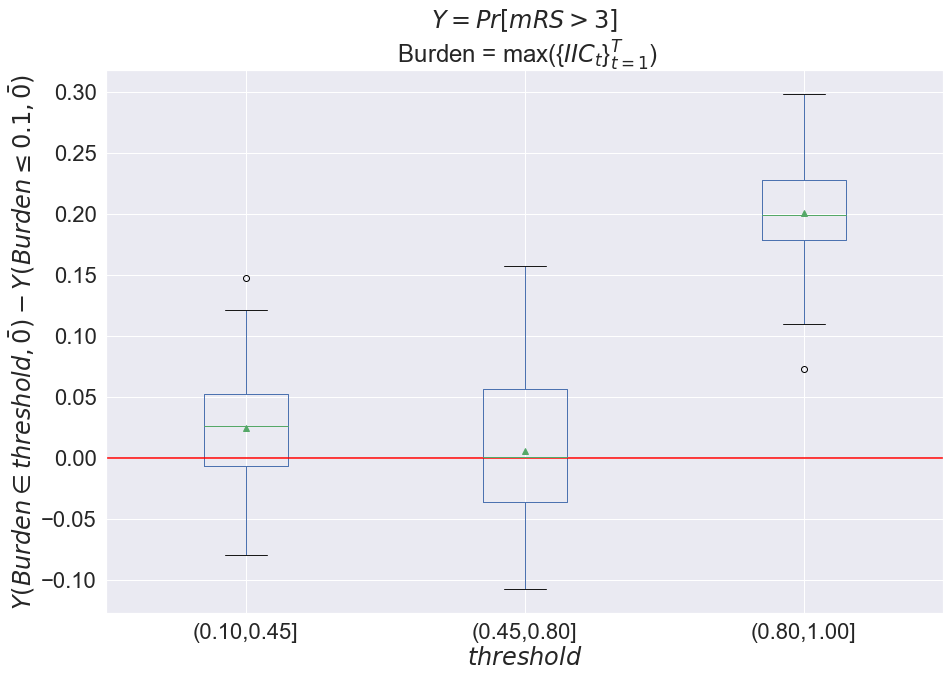

In [387]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(15,10))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,ax=ax)
    plt.axhline(0,c='red')
    plt.ylabel('$Y(Burden \\in threshold, \\bar{0}) - Y(Burden \\leq 0.1,\\bar{0})$')
    plt.xlabel('$threshold$')
    plt.title('$Y = Pr[mRS > 3]$\n Burden = %s({$IIC_t$}$_{t=1}^T$)'%(type_summary))
    fig.savefig(type_summary+'_c_pkpd.png')

In [226]:
pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum()

45.40160689014158

In [386]:
df_means

,Baseline,0.10 - 0.45,0.45 - 0.80,0.80 - 1.00
Gender,0.510490,0.463557,0.512712,0.464000
Age,58.091725,58.874082,60.512288,61.148040
marrital,0.475524,0.469388,0.504237,0.588000
Hx CVA (including TIA),0.186480,0.180758,0.190678,0.212000
Hx HTN,0.496503,0.513120,0.555085,0.564000
Hx Sz /epilepsy,0.142191,0.189504,0.211864,0.232000
Hx brain surgery,0.048951,0.122449,0.135593,0.164000
Hx CKD,0.118881,0.104956,0.105932,0.152000
Hx CAD/MI,0.174825,0.131195,0.190678,0.148000
Hx CHF,0.062937,0.084548,0.105932,0.116000


In [343]:
np.linspace(baseline_threshold,0.8,num=3)

array([0.1 , 0.45, 0.8 ])